## Import Modules

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import pickle

%matplotlib inline
plt.style.use('fivethirtyeight')

np.random.seed(42)

## Load Clean DataFrame

In [2]:
with open('./Data/clean_df.pkl', 'rb') as f:
    df = pickle.load(f)

## Import Stopword List

In [3]:
with open('./Data/stop_word_list.pkl', 'rb') as f:
    stop_word_list = pickle.load(f)

## Set Up X and y Variables and Train Test Split

In [4]:
X = df['selftext'] + " " + df['title']
y = list(df['label'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)

## TFIDF Vectorizer with Multinomial Naive Bayes Model

The Naive Bayes classifier assumes that the value of a particular feature is independent of the value of any other feature.  The Multinomial Naive Baytes model is used when the columns of your X are integer counts but it can also work with fractional counts such as tf-idf.

In [6]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_word_list)),
    ('model', MultinomialNB())])

In [7]:
params = {
    'tfidf__max_features': [1000],
    'tfidf__max_df': [0.6],
    'tfidf__min_df': [3],
    'tfidf__ngram_range': [(1,2)]
}

In [8]:
gs_multi = GridSearchCV(pipe, param_grid=params, cv=3)

In [9]:
gs_multi.fit(X_train, y_train);

In [10]:
gs_multi.score(X_train, y_train), gs_multi.score(X_test, y_test)

(0.9600340136054422, 0.9338422391857506)

In [11]:
gs_multi.best_params_ 

{'tfidf__max_df': 0.6,
 'tfidf__max_features': 1000,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 2)}

#### Pickle Multinomial Naives Bayes Model

In [12]:
with open('./Models/gs_multi.pkl', 'wb+') as f:
    pickle.dump(gs_multi, f)

#### Plot the Top 20 Words Post-Vectorization

In [13]:
sparse_data = gs_multi.best_estimator_.named_steps.tfidf.transform(X_train).toarray()
sparse_columns = gs_multi.best_estimator_.named_steps.tfidf.get_feature_names()

df_tfidf = pd.SparseDataFrame(data = sparse_data, 
                               columns = sparse_columns, 
                               default_fill_value=0)

df_tfidf.head()

,abc,able,able watch,access,account,accounts,activate,actually,add,adding,...,xfinity,year,years,years ago,yes,yesterday,youtube,youtube tv,youtubetv,yttv
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df_tfidf = df_tfidf.join(pd.DataFrame(y_test))
df_tfidf.head()
#Could use this as visual

,abc,able,able watch,access,account,accounts,activate,actually,add,adding,...,year,years,years ago,yes,yesterday,youtube,youtube tv,youtubetv,yttv,0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
df_tfidf.rename(columns = {0: 'ytest'}, inplace=True)
df_tfidf = df_tfidf.groupby('ytest').mean().T
df_tfidf.columns = ['Piracy', 'Cordcutters']
df_tfidf = df_tfidf.iloc[:,::-1]

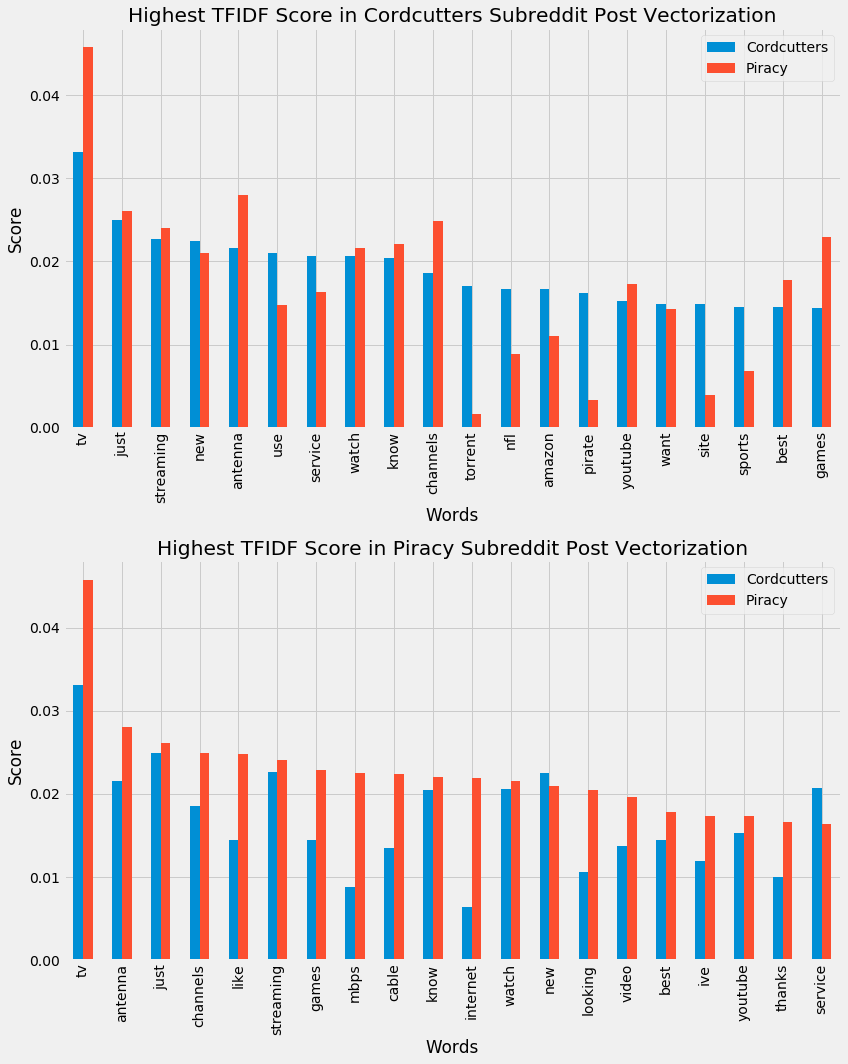

In [16]:
cc_tfidf_plot = df_tfidf.sort_values('Cordcutters', ascending=False)[:20]
piracy_tfidf_plot = df_tfidf.sort_values('Piracy', ascending=False)[:20]

figure, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12,15))
ax[0].set_xlabel('Words')
ax[1].set_xlabel('Words')
ax[0].set_ylabel('Score')
ax[1].set_ylabel('Score')

cc_tfidf_plot[:20].plot(ax = ax[0], title = 'Highest TFIDF Score in Cordcutters Subreddit Post Vectorization', kind='bar')
piracy_tfidf_plot[:20].plot(ax = ax[1], title = 'Highest TFIDF Score in Piracy Subreddit Post Vectorization', kind='bar')

figure.tight_layout();

#### Common Words Between Cordcutters and Piracy after Count Vectorization and TFIDF

In [17]:
cc_vec = ['tv', 'antenna', 'just', 'channels', 'streaming', 'internet', 'cable',
'live', 'like', 'service', 'watch', 'use', 'new', 'want', 'channel', 'sports',
'need', 'ive', 'cord', 'month'] 

cc_tiffy = list(df_tfidf.sort_values('Cordcutters', ascending=False)[:20].index)

[i for i in cc_tiffy if i in cc_vec]

['tv',
 'just',
 'streaming',
 'new',
 'antenna',
 'use',
 'service',
 'watch',
 'channels',
 'want',
 'sports']

In [18]:
piracy_vec = ['download', 'im', 'just', 'know', 'like','use', 'dont',
              'ampxb','ive','torrent','games','file', 'way','good','files',
              'piracy', 'version', 'need', 'windows', 'site']

piracy_tiffy = list(df_tfidf.sort_values('Piracy', ascending=False)[:20].index)

[i for i in piracy_tiffy if i in piracy_vec]

['just', 'like', 'games', 'know', 'ive']

In [19]:
# cc_tfidf_plot = df_tfidf.sort_values('Cordcutters', ascending=False)[:20]
# piracy_tfidf_plot = df_tfidf.sort_values('Piracy', ascending=False)[:20]

# piracy_tfidf_plot[:20].plot(kind='bar',
#                        figsize=(20,10), fontsize=25, rot=45)

# plt.xlabel('Words', fontsize=25)
# plt.ylabel('Score', fontsize=25)
# plt.title(s= 'Highest TFIDF Score in Piracy Subreddit', fontsize=25)

# figure.tight_layout();

#### Confusion Matrix for Multinomial Naives Bayes Model

In this confusion matrix true positives would be the number of posts that were predicted as 1s and are actually classified as 1s and true negatives would be the number of posts predicted as 0s and are actually classified as 0s.  We can see by the accuracy score (all correct/all) and the precision score (all positives/predicted positives) that this model is able to effectively predict which subreddit a post originates from.

In [20]:
y_pred = gs_multi.best_estimator_.predict(X_test)

In [21]:
matrix_def = [['tn','fp'], ['fn','tp']]
matrix = confusion_matrix(y_test, y_pred) 
tn, fp, fn, tp = matrix.ravel()

In [22]:
print('Matrix Definition')
print(np.array(matrix_def))
print('')
print('Confusion Matrix') 
print(matrix)
accuracy = (tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
print('')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[142  17]
 [  9 225]]

Accuracy: 0.9338422391857506
Precision: 0.9297520661157025


#### ROC Score for Multinomial Naives Bayes Model

The Receiver Operating Curve (ROC) plots the true positive rate against the false positive rate.  The false positive rate in this case would be the posts predicted as 1s that are actually classified as 0s and the false negatives would be the posts classified as 0s that are actually classified as 1s.  The false positive rate is equal to one minus the true negative rate, thus the ROC is generated by plotting the sensivity (true positive rate) and specificity (true negative rate).  The ROC gives a sense about the tradeoff between sensitivity and specificity and the closer the curve is to the upper left, the better overall accuracy of the model. 

This model represnts the tradeoff in which the higher the true positive rate, the more false positive the classifier produces.  This is demonstrated in the ROC Curve in that it is very close to the upper left corner and its area under the curve (AUC) is 0.98, where a perfect classifier will have a ROC-AUC of 1.

In [23]:
fpr, tpr, threshold = roc_curve(y_test, gs_multi.predict_proba(X_test)[:, 1])

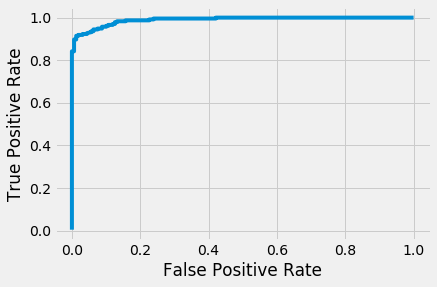

In [24]:
plt.figure()
plt.plot(fpr, tpr)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [25]:
roc_auc_score(y_test, gs_multi.predict_proba(X_test)[:, 1])

0.9894640649357631

## TFIDF Vectorizer with Logistic Regression Model

Logistic regression is a model used to estimate the probability that an instance belongs to a particular class.  If the estimate probability is greater than 50%, then the model predicts that the instance belongs to that class.  In the case of TFIDF, the probability of success is the scalerd frequency (whether a term is common or rare among all documents).  The C is the inverse of regularization strength where the smaller values specify stronger regularization. 
The L1 and L2 are used to specify the penalty (simlar to Lasso/Ridge) in linear regression.  "Class weight=balanced" works by replicating the smaller class until you have as many samples as in the larger one.  I chose to use this since there was about a 60/40 split in my classes.

In [26]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_word_list)),
    ('logreg', LogisticRegression())])

#use idf and smooth idf

In [27]:
params = {
    'tfidf__max_features': [2000],
    'tfidf__max_df': [0.6],
    'tfidf__min_df': [3],
    'tfidf__ngram_range': [(1,2)],
    'logreg__penalty': ['l2'],
    'logreg__C': [1],
    'logreg__class_weight': ['balanced']
}

In [28]:
gs_logreg = GridSearchCV(pipe, param_grid=params, cv=3)

In [29]:
gs_logreg.fit(X_train, y_train);

In [30]:
gs_logreg.score(X_train, y_train), gs_logreg.score(X_test, y_test)

(0.9812925170068028, 0.9465648854961832)

In [31]:
gs_logreg.best_params_ 

{'logreg__C': 1,
 'logreg__class_weight': 'balanced',
 'logreg__penalty': 'l2',
 'tfidf__max_df': 0.6,
 'tfidf__max_features': 2000,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 2)}

#### Pickle Logistic Regression Model

In [32]:
with open('./Models/gs_logreg.pkl', 'wb+') as f:
    pickle.dump(gs_logreg, f)

#### Confusion Matrix for Logistic Regression Model

This model performs the best in terms of accuracy and precision.  These scores were most likely helped by the tuning of parameters that we conducted in the gridsearch.   

In [33]:
y_pred = gs_logreg.best_estimator_.predict(X_test)
y_proba = gs_logreg.predict_proba(X_test)

In [34]:
matrix_def = [['tn','fp'], ['fn','tp']]
matrix = confusion_matrix(y_test, y_pred) 
tn, fp, fn, tp = matrix.ravel()

#look at all rows where y_pred and y_test are not martching up.

In [35]:
print('Matrix Definition')
print(np.array(matrix_def))
print('')
print('Confusion Matrix') 
print(matrix)
accuracy = (tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
print('')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')

#Pull out in Xtest the false positives and false negatives and fidn out why model is trippign up 

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[151   8]
 [ 13 221]]

Accuracy: 0.9465648854961832
Precision: 0.9650655021834061


#### Posts Where Y-Test and Y-Pred Don't Match

I will take some posts that were false positives and false negatives under this model and I will try to demonstrate some patterns that exist during my presentation.

In [36]:
model_analysis_df = pd.DataFrame(X_test, columns=['Raw Text'])
model_analysis_df.reset_index(drop=True, inplace=True)

In [37]:
y_proba_df = pd.DataFrame(y_proba)
y_proba_df.reset_index(drop=True, inplace=True)

In [38]:
model_analysis_df['actual'] = list(y_test)
model_analysis_df['predicted'] = y_pred
model_analysis_df['probability'] = y_proba_df[1]
model_analysis_df.head()

,Raw Text,actual,predicted,probability
0,what is a good antenna for my area here my li...,1,1,0.765103
1,i have a k video of the original star wars mov...,0,0,0.235725
2,frustrated cordcutter hereneed some help with ...,1,1,0.792755
3,i tried installing it with this method https//...,0,0,0.185841
4,i have an hdtv with only one coaxial input i b...,1,1,0.871274


In [39]:
false_pos = model_analysis_df.loc[(model_analysis_df['actual'] < model_analysis_df['predicted'])]
false_pos

,Raw Text,actual,predicted,probability
12,i am trying to watch the arrow but cant on net...,0,1,0.662967
16,jurassicworldfallenkingdompwebdlddhfgt or jur...,0,1,0.579002
17,whenever i try to watch hour movies i always ...,0,1,0.565523
31,maybe i will take the th or th one,0,1,0.512740
113,has anyone figured out how to do this yet been...,0,1,0.505578
214,without my isp becoming suspicious how many pe...,0,1,0.510168
259,tldr why can i buy big mac at a reasonable pr...,0,1,0.503015
366,dish is hiring an investigator to research an...,0,1,0.527790


In [40]:
false_neg = model_analysis_df.loc[(model_analysis_df['actual'] > model_analysis_df['predicted'])]
false_neg

,Raw Text,actual,predicted,probability
11,there is some good content on free streaming m...,1,0,0.307998
24,netflix has deleted every user review ever po...,1,0,0.487513
48,it seems that simpsons world is no longer a fe...,1,0,0.328863
62,i have gb left afraid ill go over my cap help,1,0,0.379535
65,every movie it works for a few minutes then th...,1,0,0.395047
82,fubo rolling out more k beta broadcasts,1,0,0.482258
89,moviepass is uncanceling peoples accounts,1,0,0.429816
195,i feel silly paying for all the same free cont...,1,0,0.482292
197,i know now is direct from them and go is from ...,1,0,0.381693
229,tribune calls off b buyout by sinclair,1,0,0.470162


In [41]:
for i, value in enumerate(list(false_pos.loc[:,'Raw Text'])):
    print(i+1, value)

1 i am trying to watch the arrow but cant on netflix because im in canada tried using a vpn but netflix detected it are there any other ways to get past this or any other websites to watch this show how to watch netflix shows not available in my region
2 jurassicworldfallenkingdompwebdlddhfgt or  jurassicworldpwebdlhacevoethd which one is best ethd or fgt
3 whenever i try to watch  hour movies i always have to pause and let it load a little but even then i still encounter buffers i have about /mbps at home and i still cant watch anything consistently stable i was wondering if leonflix would add an online feature where we can download movies and tv shows and watch it without the internet if theres another way of downloading movies and tv shows safely for now please link me to those sources thank you download/offline feature
4  maybe i will take the th or th one
5 has anyone figured out how to do this yet been trying different ways and just cant figure out how to do it yet any advice wou

In [42]:
for i, value in enumerate(list(false_neg.loc[:,'Raw Text'])):
    print(i+1, value)

1 there is some good content on free streaming media channels but scrolling through the menus is a major annoyance is anyone aware of a web site that lists whats showing from each of these sources i know whats showing needs clarification title year genres rating link to description on source may be sufficient perhaps this is a candidate for ifttt i would rather not start solving that problem if someone else already has any allinone pluto crackle vudu and so forth reference
2  netflix has deleted every user review ever posted to its website
3 it seems that simpsons world is no longer a feature when i click on simpsons i get just an episode list of   or  episodes per season clicking more episodes brings me to a clunky episode list by season what happened to the different style playlists etc anyone know what happened to simpsons world on fxnow fire tv
4  i have gb left afraid ill go over my cap help
5 every movie it works for a few minutes then the video freezes and audio keeps playing fo

#### ROC Score for Logistic Regression Model

This model has a ROC-AUC score that is just slightly lower than the Multinomial NB model's, but it is still very high. 

In [43]:
fpr, tpr, threshold = roc_curve(y_test, gs_logreg.predict_proba(X_test)[:, 1])

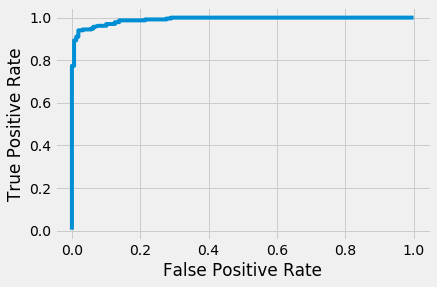

In [44]:
plt.figure()
plt.plot(fpr, tpr)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [45]:
roc_auc_score(y_test, gs_logreg.predict_proba(X_test)[:, 1])

0.9907944955114767

## TFIDF Vectorizer with Random Forest Classifier 

Random Forest builds an ensemble of decision trees.  Instead of searching for the most important feature while splitting a node, Random Forest searches for the best feature among a random subset of features.

In [46]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_word_list)),
    ('rf', RandomForestClassifier())])

In [47]:
params = {
    'tfidf__max_features': [2000],
    'tfidf__max_df': [0.7],
    'tfidf__min_df': [4],
    'tfidf__ngram_range': [(1,2)],
    'rf__n_estimators': [100],
    'rf__n_jobs': [1],
    'rf__min_samples_split': [3],
    'rf__min_samples_leaf': [3],
    'rf__class_weight': [None, 'balanced', 'balanced_subsample']
}

In [48]:
gs_rf = GridSearchCV(pipe, param_grid=params, cv=3)

In [49]:
gs_rf.fit(X_train, y_train);

In [50]:
gs_rf.score(X_train, y_train), gs_rf.score(X_test, y_test)

(0.9549319727891157, 0.9211195928753181)

In [51]:
gs_rf.best_params_ 

{'rf__class_weight': None,
 'rf__min_samples_leaf': 3,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 100,
 'rf__n_jobs': 1,
 'tfidf__max_df': 0.7,
 'tfidf__max_features': 2000,
 'tfidf__min_df': 4,
 'tfidf__ngram_range': (1, 2)}

#### Pickle Random Forest Classifier

In [52]:
with open('./Models/gs_rt.pkl', 'wb+') as f:
    pickle.dump(gs_rf, f)

#### Confusion Matrix for Random Forest Classifier

In [53]:
y_pred = gs_rf.best_estimator_.predict(X_test)

In [54]:
matrix_def = [['tn','fp'], ['fn','tp']]
matrix = confusion_matrix(y_test, y_pred) 
tn, fp, fn, tp = matrix.ravel()

In [55]:
print('Matrix Definition')
print(np.array(matrix_def))
print('')
print('Confusion Matrix') 
print(matrix)
accuracy = (tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
print('')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[136  23]
 [  8 226]]

Accuracy: 0.9211195928753181
Precision: 0.9076305220883534


#### ROC Score

In [56]:
fpr, tpr, threshold = roc_curve(y_test, gs_rf.predict_proba(X_test)[:, 1])

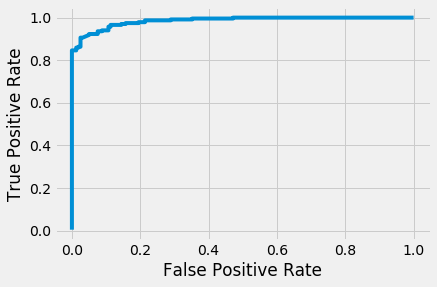

In [57]:
plt.figure()
plt.plot(fpr, tpr)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [58]:
roc_auc_score(y_test, gs_rf.predict_proba(X_test)[:, 1])

0.985096489813471

## TFIDF Vectorizer Decision Tree Classifier

A decision tree divides the data set into smaller data sets until reaching a small enough set that contains data points that fall under one class. A partition is considered to be pure once all data of a specific class exists in it.  The min_samples_split represents the minimum number of samples required to split an internal node and the min_samples_leaf represents the minimum number of samples required to be at a leaf node.

In [59]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_word_list)),
    ('dt', DecisionTreeClassifier())])

In [60]:
params = {
    'tfidf__max_features': [1000],
    'tfidf__max_df': [0.7],
    'tfidf__min_df': [3],
    'tfidf__ngram_range': [(1,2)],
    'dt__min_samples_split': [4],
    'dt__min_samples_leaf': [2],
    'dt__class_weight': ['balanced']
}

In [61]:
gs_dt = GridSearchCV(pipe, param_grid=params, cv=3)

In [62]:
gs_dt.fit(X_train, y_train);

In [63]:
gs_dt.score(X_train, y_train), gs_dt.score(X_test, y_test)

(0.9498299319727891, 0.8854961832061069)

In [64]:
gs_dt.best_params_ 

{'dt__class_weight': 'balanced',
 'dt__min_samples_leaf': 2,
 'dt__min_samples_split': 4,
 'tfidf__max_df': 0.7,
 'tfidf__max_features': 1000,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 2)}

#### Pickle Decision Tree Classifier

In [65]:
with open('./Models/gs_dt.pkl', 'wb+') as f:
    pickle.dump(gs_dt, f)

#### Confusion Matrix for Decision Tree Classifier

The accuracy and precision scores are significantly worse under this model than the logistical and Multinomial NB models.  Due to the decision tree's tendency to overfit, it tends to not produce great results if the training data is somewhat different thant the scoring data.  

In [66]:
y_pred = gs_dt.best_estimator_.predict(X_test)

In [67]:
matrix_def = [['tn','fp'], ['fn','tp']]
matrix = confusion_matrix(y_test, y_pred) 
tn, fp, fn, tp = matrix.ravel()

In [68]:
print('Matrix Definition')
print(np.array(matrix_def))
print('')
print('Confusion Matrix') 
print(matrix)
accuracy = (tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
print('')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[151   8]
 [ 37 197]]

Accuracy: 0.8854961832061069
Precision: 0.9609756097560975


#### ROC Score

In [69]:
fpr, tpr, threshold = roc_curve(y_test, gs_dt.predict_proba(X_test)[:, 1])

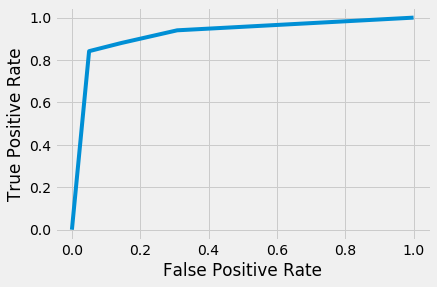

In [70]:
plt.figure()
plt.plot(fpr, tpr)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [71]:
roc_auc_score(y_test, gs_dt.predict_proba(X_test)[:, 1])

0.9223915497500403

# <center>Scores Table</center>

<center>Model</center>                   |<center>Test Score</center> |<center>ROC AUC</center>
:--------------------------------------- |--------------|-------------|------------------------
Multinomial Naives Bayes</center>        |<center>0.936</center>      |<center>0.988</center>
Logistic Regression</center>             |<center>0.946</center>      |<center>0.987</center> 
Random Forest</center>                   |<center>0.911</center>      |<center>0.978</center>
Decision Tree</center>                   |<center>0.842</center>      |<center>0.880</center>